In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mass import MassSpectrum, VanKrevelen
import time
import pandas as pd

/home/dpreer/Polarwind/nhslab/masslib/mass.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes as inset_axes_func


In [3]:
def brutto_gen_dummy(
    elems: str = 'CHONS',
    round_search: int = 5
):
    """Generates brutto formula 
    :param elems: CHO - find just CHO formules, CHON - add nitrigen to find, CHONS - add sulfur
    :param round: default 5, round of caclulated mass from brutto by this
    :return: dict {mass : [C, H, O, N, S], ...}
    """

    H = 1.007825
    C = 12.000000
    N = 14.003074
    O = 15.994915
    S = 31.972071

    brutto_gen = {}
    for c in range(1,51,1):
        for h in range (0, 100,1):
            for o in range (0, 50,1):
                for n in range (0, 4,1):
                    for s in range (0, 2, 1):
                        
                        # compounds with these atomic ratios are unlikely to meet
                        if h/c > 2 or h/c < 0.25:
                            continue
                        if o/c > 1:
                            continue

                        # it is unlikely that there will be low molecular weight molecules containing sulfur or nitrogen
                        if c < 15 and n > 0:
                            continue
                        if c < 25 and s > 0:
                            continue
                        
                        #check hydrogen atom parity
                        if (h%2 == 0 and n%2 != 0) or (n%2 == 0 and h%2 != 0):
                            continue

                        if n > 0 and 'N' not in elems:
                            continue
                        if s > 0 and 'S' not in elems:
                            continue
                        
                        mass = round(c*C + h*H + o*O + n*N + s*S, round_search)
                        brutto_gen[mass] = [c, h, o, n, s]

    return brutto_gen

In [4]:
generated_bruttos_table = brutto_gen_dummy()

In [5]:
len(generated_bruttos_table)

290483

In [6]:
def get_dataframe(gen):
    return pd.DataFrame([{
        "mass": i,
        "C": gen[i][0],
        "H": gen[i][1],
        "O": gen[i][2],
        "N": gen[i][3],
        "S": gen[i][4],
    } for i in gen])

In [7]:
gdf = get_dataframe(generated_bruttos_table)
gdf = gdf.sort_values("mass")

In [8]:
gdf

,mass,C,H,O,N,S
0,14.01565,1,2,0,0,0
2,26.01565,2,2,0,0,0
5,28.03130,2,4,0,0,0
1,30.01056,1,2,1,0,0
8,38.01565,3,2,0,0,0
...,...,...,...,...,...,...
288882,1549.44420,50,91,49,3,1
289282,1551.45985,50,93,49,3,1
289682,1553.47550,50,95,49,3,1
290082,1555.49115,50,97,49,3,1


In [9]:
mapper = {"m/z": "mass", "I": "I"}
ignore_columns=["Name", "I %", "Res.", "S/N"]

In [10]:
T = time.time()
fa_1 = MassSpectrum().load("data/fa.csv",
                         mapper=mapper,
                         sep=',',
                         ignore_columns=ignore_columns)
fa_1 = fa_1.assign_dummy(elems='CHONS').drop_unassigned()
vk_1 = VanKrevelen(fa_1.table)
print(time.time() - T)

8.786583423614502


In [11]:
T = time.time()
mapper = {"m/z": "mass", "I": "I"}
fa_2 = MassSpectrum().load("data/fa.csv",
                         mapper=mapper,
                         sep=',',
                         ignore_columns=ignore_columns)
fa_2 = fa_2.assign(gdf, elems=list('CHONS')).drop_unassigned()
vk_2 = VanKrevelen(fa_2.table)
print(time.time() - T)

2.423729181289673


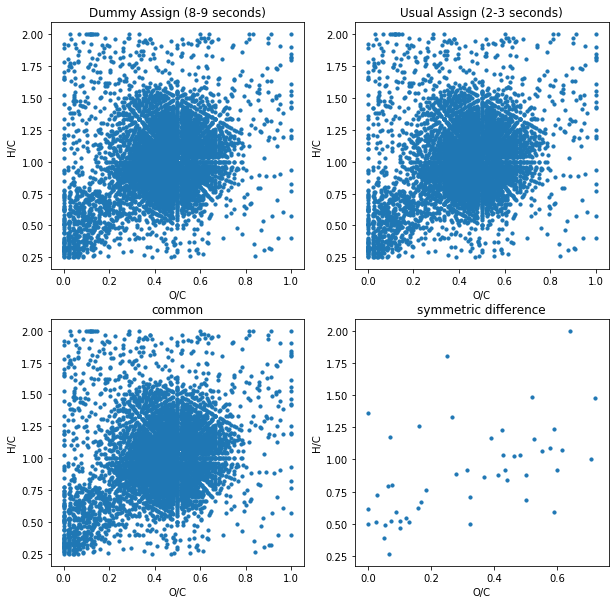

In [18]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("Dummy Assign (8-9 seconds)")
VanKrevelen(fa_1.table).draw_scatter()
plt.subplot(222)
plt.title("Usual Assign (2-3 seconds)")
VanKrevelen(fa_2.table).draw_scatter()
plt.subplot(223)
plt.title("common")
VanKrevelen((fa_1 & fa_2).table).draw_scatter()
plt.subplot(224)
plt.title('symmetric difference')
VanKrevelen((fa_1 ^ fa_2).table).draw_scatter()